In [1]:
import numpy as np 
import pandas as pd
import string
from tqdm import tqdm
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import  hstack
import nltk
import re
_wnl = nltk.WordNetLemmatizer()
from sklearn import feature_extraction
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Using TensorFlow backend.


In [2]:
def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(text):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation),''))
    return " ".join(re.findall(r'\w+', text, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]
def join_tok(text):
    return " ".join(text).lower()

In [3]:
def pre_process(texts):
    lst=[]
    for text in tqdm(texts):
        clean_text= clean(text)
        tok_text= get_tokenized_lemmas(clean_text)
        remov_stp= remove_stopwords(tok_text)
        lst.append(join_tok(remov_stp))
    return lst

In [4]:
data= pd.read_csv('../input/aossie-click-bait-dataset/clickBait_Data.csv')

In [5]:
data.head()

,index,id,titles,clickbait
0,6574,6575,25 Things We Learned From Julia Louis-Dreyfus ...,1
1,39655,39656,John Brennan: Trump's 'Nazi Germany' tweet to ...,0
2,44513,44514,"TruthRevolt.org: ISIS Stands For ""Israeli Secr...",0
3,44205,44206,Peak Millennial? Cities Cant Assume a Continue...,0
4,11106,11107,This Entire City Is Made Out Of Ice And It Wil...,1


In [6]:
titles=  pre_process(data['titles'])

100%|██████████| 59172/59172 [00:13<00:00, 4278.14it/s]


In [7]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=300, stop_words='english',ngram_range=(1,4))


In [8]:
tfidf_vect.fit(titles)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=300, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [9]:
titleFeatures= tfidf_vect.transform(titles).toarray()

In [10]:
labels= data['clickbait'].tolist()

In [11]:
train_feat, test_feat, train_labels, test_labels= train_test_split(titleFeatures,labels,test_size= 0.2,shuffle=True)

In [12]:

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

In [13]:
mnb.fit(train_feat,train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
prediction= mnb.predict(test_feat)

In [15]:
accuracy_score(test_labels,prediction)

0.7094212082805239

In [16]:
featureLen= train_feat.shape[1]

In [17]:
model= Sequential()
model.add(Dense(300,activation='relu', input_shape=(featureLen,)))
model.add(Dense(160,activation='relu'))
model.add(Dense(80,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


Instructions for updating:
Colocations handled automatically by placer.


In [18]:
filepath=r"CB1-tfidf_nn_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [19]:
model.compile(loss = 'mse', optimizer='adam',metrics = ['accuracy'])


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               48160     
_________________________________________________________________
dense_3 (Dense)              (None, 80)                12880     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 156,431
Trainable params: 156,431
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(train_feat,train_labels,epochs=25,batch_size=3,verbose=1,validation_split=0.05, shuffle=True,callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 44970 samples, validate on 2367 samples
Epoch 1/25
44970/44970 [==============================] - 58s 1ms/step - loss: 0.1919 - acc: 0.6991 - val_loss: 0.1858 - val_acc: 0.7047

Epoch 00001: val_acc improved from -inf to 0.70469, saving model to CB1-tfidf_nn_weights-improvement-01-0.70.hdf5
Epoch 2/25
44970/44970 [==============================] - 55s 1ms/step - loss: 0.1805 - acc: 0.7203 - val_loss: 0.1804 - val_acc: 0.7229

Epoch 00002: val_acc improved from 0.70469 to 0.72286, saving model to CB1-tfidf_nn_weights-improvement-02-0.72.hdf5
Epoch 3/25
44970/44970 [==============================] - 55s 1ms/step - loss: 0.1696 - acc: 0.7411 - val_loss: 0.1796 - val_acc: 0.7212

Epoch 00003: val_acc did not improve from 0.72286
Epoch 4/25
44970/44970 [==============================] - 55s 1ms/step - loss: 0.1578 - acc: 0.7628 - val_loss: 0.1770 - val_acc: 0.7313

Epoch 00004: val_acc improved from 0.72286 to 0.73131, saving model to

In [22]:
prediction= model.predict(test_feat)
YClass= np.zeros((len(prediction)))



In [23]:
acc,scor= model.evaluate(test_feat,test_labels)

11835/11835 [==============================] - 0s 34us/step


In [24]:
acc, scor

(0.18669120177318135, 0.7496408956082098)

In [25]:
for i in range(len(prediction)):
    if prediction[i][0]>=0.5:
        YClass[i]=1
    else:
        YClass[i]=0

In [26]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
#matrix1 = confusion_matrix(test_labels, prediction)



In [27]:
matrix1 = confusion_matrix(test_labels, YClass)


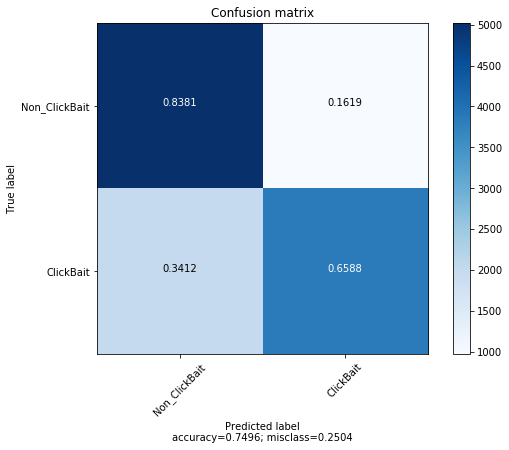

In [28]:
plot_confusion_matrix(cm=matrix1,target_names=['Non_ClickBait', 'ClickBait'])